In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# when CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment
# https://stackoverflow.com/a/73992912

In [2]:
# essential packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

# python modules
import matplotlib.pyplot as plt
import glob
import yaml
import numpy as np
import pandas as pd
import random

# custom module
from aux_code.learning_preprocess import convert_from_NED_to_Robotic, get_trajectory_before_pass, check_dimension

In [3]:
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

## Data Loader

In [4]:
# file_name = "aisdk_20180101"
# howmany=200
# using_file_indices = np.arange(0,howmany)

In [5]:
# df_entire_pass = pd.DataFrame()

# # https://www.w3resource.com/pandas/dataframe/dataframe-to_pickle.php
# for using_file_idx in using_file_indices:
#     unpickled_df = pd.read_pickle("./dk_csv_20180101/{}_{}.pkl".format(file_name, str(using_file_idx)))
#     unpickled_df
#     df_entire_pass = pd.concat([df_entire_pass, unpickled_df])

In [6]:
file_name = "synthetic"
howmany=100
using_file_indices = np.arange(0,howmany)

In [7]:
df_entire_pass = pd.DataFrame()

# https://www.w3resource.com/pandas/dataframe/dataframe-to_pickle.php
for using_file_idx in using_file_indices:
    unpickled_df = pd.read_pickle("./synthetic_data/noise/{}_{}.pkl".format(file_name, str(using_file_idx)))
    unpickled_df
    df_entire_pass = pd.concat([df_entire_pass, unpickled_df])

In [8]:
df_entire_pass

,x,y,v_x,v_y,global_x,global_y,rel_dist,rel_bearing,rel_bearing_diff,comp_bearing,comp_bearing_diff,Heading,situation,sin_rel_bearing,cos_rel_bearing,sin_comp_bearing,cos_comp_bearing,valid,obj_index,label
0,79.098468,55.725545,-3.845899,-0.289928,-55.725545,79.098468,96.756933,0.613745,0.019764,2.184542,0.019764,157,crossing,0.575933,0.817497,0.817497,-0.575933,True,0,L
1,74.629831,55.158882,-4.468637,-0.566662,-55.158882,74.629831,92.801476,0.636488,0.022743,2.207285,0.022743,157,crossing,0.594375,0.804188,0.804188,-0.594375,True,0,L
2,70.401839,54.735901,-4.227992,-0.422982,-54.735901,70.401839,89.176442,0.660857,0.024368,2.231653,0.024368,157,crossing,0.613793,0.789467,0.789467,-0.613793,True,0,L
3,64.799534,53.883762,-5.602305,-0.852139,-53.883762,64.799534,84.275971,0.693682,0.032826,2.264479,0.032826,157,crossing,0.639373,0.768897,0.768897,-0.639373,True,0,L
4,61.438595,52.070334,-3.360938,-1.813427,-52.070334,61.438595,80.535835,0.703052,0.009369,2.273848,0.009369,157,crossing,0.646549,0.762873,0.762873,-0.646549,True,0,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,-221.518394,-61.762385,-0.284594,-0.856589,61.762385,-221.518394,229.967370,-2.869684,0.003263,-1.298888,0.003263,182,headon,-0.268570,-0.963260,-0.963260,0.268570,True,99,R
267,-220.643143,-61.087585,0.875251,0.674800,61.087585,-220.643143,228.943420,-2.871497,-0.001812,-1.300700,-0.001812,182,headon,-0.266824,-0.963745,-0.963745,0.266824,True,99,R
268,-220.709009,-61.083340,-0.065866,0.004245,61.083340,-220.709009,229.005767,-2.871591,-0.000095,-1.300795,-0.000095,182,headon,-0.266733,-0.963771,-0.963771,0.266733,True,99,R
269,-220.158826,-60.721471,0.550183,0.361869,60.721471,-220.158826,228.379084,-2.872476,-0.000885,-1.301679,-0.000885,182,headon,-0.265880,-0.964006,-0.964006,0.265880,True,99,R


### pre-processing

In [9]:
df_entire_pass['heading_converted']  = np.deg2rad(df_entire_pass['Heading'])
# lambda function method: very fast! 
# https://stackoverflow.com/questions/71249186/applying-function-to-column-in-a-dataframe
df_entire_pass['heading_converted'] = df_entire_pass['heading_converted'].apply(convert_from_NED_to_Robotic)


In [10]:
df_entire_pass

,x,y,v_x,v_y,global_x,global_y,rel_dist,rel_bearing,rel_bearing_diff,comp_bearing,...,Heading,situation,sin_rel_bearing,cos_rel_bearing,sin_comp_bearing,cos_comp_bearing,valid,obj_index,label,heading_converted
0,79.098468,55.725545,-3.845899,-0.289928,-55.725545,79.098468,96.756933,0.613745,0.019764,2.184542,...,157,crossing,0.575933,0.817497,0.817497,-0.575933,True,0,L,-1.169371
1,74.629831,55.158882,-4.468637,-0.566662,-55.158882,74.629831,92.801476,0.636488,0.022743,2.207285,...,157,crossing,0.594375,0.804188,0.804188,-0.594375,True,0,L,-1.169371
2,70.401839,54.735901,-4.227992,-0.422982,-54.735901,70.401839,89.176442,0.660857,0.024368,2.231653,...,157,crossing,0.613793,0.789467,0.789467,-0.613793,True,0,L,-1.169371
3,64.799534,53.883762,-5.602305,-0.852139,-53.883762,64.799534,84.275971,0.693682,0.032826,2.264479,...,157,crossing,0.639373,0.768897,0.768897,-0.639373,True,0,L,-1.169371
4,61.438595,52.070334,-3.360938,-1.813427,-52.070334,61.438595,80.535835,0.703052,0.009369,2.273848,...,157,crossing,0.646549,0.762873,0.762873,-0.646549,True,0,L,-1.169371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,-221.518394,-61.762385,-0.284594,-0.856589,61.762385,-221.518394,229.967370,-2.869684,0.003263,-1.298888,...,182,headon,-0.268570,-0.963260,-0.963260,0.268570,True,99,R,-1.605703
267,-220.643143,-61.087585,0.875251,0.674800,61.087585,-220.643143,228.943420,-2.871497,-0.001812,-1.300700,...,182,headon,-0.266824,-0.963745,-0.963745,0.266824,True,99,R,-1.605703
268,-220.709009,-61.083340,-0.065866,0.004245,61.083340,-220.709009,229.005767,-2.871591,-0.000095,-1.300795,...,182,headon,-0.266733,-0.963771,-0.963771,0.266733,True,99,R,-1.605703
269,-220.158826,-60.721471,0.550183,0.361869,60.721471,-220.158826,228.379084,-2.872476,-0.000885,-1.301679,...,182,headon,-0.265880,-0.964006,-0.964006,0.265880,True,99,R,-1.605703


## Train, test data split

In [11]:
# https://www.geeksforgeeks.org/how-to-randomly-select-elements-of-an-array-with-numpy-in-python/

np.random.seed(0) # right now for consistent data testing


# for train, test data
use_df = df_entire_pass.loc[(df_entire_pass.valid == True)] # to be used, valid df
unique_id = use_df.obj_index.unique()

# data split
train_data_size = int(len(unique_id) * 0.8)
test_data_size = len(unique_id) - train_data_size
print("train size: {} \n test size: {}".format(train_data_size, test_data_size))

# split obj indexes
train_obj_id = np.random.choice(unique_id, size = train_data_size, replace=False)
test_obj_id = np.setdiff1d(unique_id, train_obj_id)
train_obj_id

train size: 80 
 test size: 20


array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
       24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
       51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91,
       59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84,
       14, 89, 19, 29, 49, 97, 98, 69, 20, 94, 72, 77])

In [12]:
# train data
df_cropped_train = get_trajectory_before_pass(df_entire_pass, train_obj_id)
df_cropped_train

,x,y,v_x,v_y,global_x,global_y,rel_dist,rel_bearing,rel_bearing_diff,comp_bearing,...,Heading,situation,sin_rel_bearing,cos_rel_bearing,sin_comp_bearing,cos_comp_bearing,valid,obj_index,label,heading_converted
0,90.558639,-41.806337,-4.520553,0.986774,41.806337,90.558639,99.742854,-0.432499,-0.009580,1.138297,...,186,headon,-0.419141,0.907921,0.907921,0.419141,True,26,R,-1.675516
1,85.555552,-42.760469,-5.003087,-0.954132,42.760469,85.555552,95.646277,-0.463486,-0.030987,1.107311,...,186,headon,-0.447069,0.894500,0.894500,0.447069,True,26,R,-1.675516
2,81.497191,-41.611229,-4.058361,1.149240,41.611229,81.497191,91.505664,-0.472080,-0.008594,1.098717,...,186,headon,-0.454739,0.890625,0.890625,0.454739,True,26,R,-1.675516
3,76.836958,-43.025186,-4.660234,-1.413958,43.025186,76.836958,88.062959,-0.510454,-0.038374,1.060343,...,186,headon,-0.488573,0.872523,0.872523,0.488573,True,26,R,-1.675516
4,71.898786,-41.912358,-4.938172,1.112828,41.912358,71.898786,83.223080,-0.527778,-0.017324,1.043019,...,186,headon,-0.503615,0.863928,0.863928,0.503615,True,26,R,-1.675516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,14.128247,19.014310,-2.305002,0.096262,-19.014310,14.128247,23.688633,0.931769,0.076198,2.502566,...,180,headon,0.802677,0.596415,0.596415,-0.802677,True,77,L,-1.570796
1715,10.211267,19.609594,-3.916981,0.595284,-19.609594,10.211267,22.108960,1.090704,0.158935,2.661500,...,180,headon,0.886952,0.461861,0.461861,-0.886952,True,77,L,-1.570796
1716,7.706312,19.849375,-2.504955,0.239781,-19.849375,7.706312,21.292837,1.200469,0.109765,2.771266,...,180,headon,0.932209,0.361920,0.361920,-0.932209,True,77,L,-1.570796
1717,3.387284,20.646722,-4.319028,0.797347,-20.646722,3.387284,20.922735,1.408186,0.207717,2.978982,...,180,headon,0.986808,0.161895,0.161895,-0.986808,True,77,L,-1.570796


In [13]:
np.all(df_cropped_train['label'])

True

In [14]:
np.any(np.isnan(df_cropped_train['y']))

False

In [15]:
# df_cropped_train = df_cropped_train[df_cropped_train['Heading_by_xy'].notna()]  # drop na for Heaing_by_xy
# np.any(np.isnan(df_cropped_train['Heading_by_xy']))

In [16]:
# test data
df_cropped_test = get_trajectory_before_pass(df_entire_pass, test_obj_id)
df_cropped_test

,x,y,v_x,v_y,global_x,global_y,rel_dist,rel_bearing,rel_bearing_diff,comp_bearing,...,Heading,situation,sin_rel_bearing,cos_rel_bearing,sin_comp_bearing,cos_comp_bearing,valid,obj_index,label,heading_converted
0,94.940486,27.645551,-5.110338,-0.961385,-27.645551,94.940486,98.883630,0.283353,0.004860,1.854149,...,180,headon,0.279577,0.960123,0.960123,-0.279577,True,9,L,-1.570796
1,89.022863,28.666075,-5.917622,1.020525,-28.666075,89.022863,93.524403,0.311523,0.028170,1.882320,...,180,headon,0.306509,0.951868,0.951868,-0.306509,True,9,L,-1.570796
2,83.139173,27.636134,-5.883691,-1.029941,-27.636134,83.139173,87.612088,0.320918,0.009394,1.891714,...,180,headon,0.315437,0.948946,0.948946,-0.315437,True,9,L,-1.570796
3,77.905900,27.715195,-5.233272,0.079061,-27.715195,77.905900,82.688943,0.341790,0.020872,1.912586,...,180,headon,0.335174,0.942156,0.942156,-0.335174,True,9,L,-1.570796
4,73.023087,28.771000,-4.882813,1.055805,-28.771000,73.023087,78.486570,0.375322,0.033532,1.946118,...,180,headon,0.366572,0.930390,0.930390,-0.366572,True,9,L,-1.570796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,4.066314,-77.046192,-1.002544,0.270178,77.046192,4.066314,77.153423,-1.518068,-0.012738,0.052729,...,178,headon,-0.998610,0.052704,0.052704,0.998610,True,96,R,-1.535890
363,2.659151,-77.485501,-1.407163,-0.439309,77.485501,2.659151,77.531116,-1.536492,-0.018424,0.034305,...,178,headon,-0.999412,0.034298,0.034298,0.999412,True,96,R,-1.535890
364,1.917513,-76.590684,-0.741638,0.894818,76.590684,1.917513,76.614683,-1.545766,-0.009274,0.025031,...,178,headon,-0.999687,0.025028,0.025028,0.999687,True,96,R,-1.535890
365,1.851373,-77.448461,-0.066140,-0.857777,77.448461,1.851373,77.470586,-1.546896,-0.001131,0.023900,...,178,headon,-0.999714,0.023898,0.023898,0.999714,True,96,R,-1.535890


In [17]:
# df_cropped_test = df_cropped_test[df_cropped_test['Heading_by_xy'].notna()] # drop na for Heaing_by_xy
# np.any(np.isnan(df_cropped_test['Heading_by_xy']))

## Train, test data encoding and extract specific cell

In [18]:
# columns to extract
columns_for_x = ['x', 'y', 'rel_dist', 'sin_comp_bearing', 'cos_comp_bearing', 'heading_converted']
# columns_for_x = ['x', 'y', 'v_x', 'v_y', 'rel_dist', 'rel_bearing', 'heading_converted']
# columns_for_x = ['r_value', 'atan']
columns_for_y = ['label']
binary_classification = True

# one hot encoding for y target
one_hot_lookup = torch.eye(2).tolist()

# df to array
X_train = []
X_test = []
y_train = []
y_test = []


#### train dataset
for obj_id, df_by_ID in df_cropped_train.groupby('obj_index'):
    X_train.append(df_by_ID[columns_for_x].values.tolist())

    if binary_classification:
        # y_train.append(one_hot_lookup[0] if df_by_ID[columns_for_y].values[-1][0] == "L" else one_hot_lookup[1]) # last row, only char
        y_train.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" else 1) # last row, only char
    else:
        # print(df_by_ID['bow_crossing'].values[-1] )
        y_train.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" and df_by_ID['bow_crossing'].values[-1] == True\
                       else 1 if df_by_ID[columns_for_y].values[-1][0] == "L" and df_by_ID['bow_crossing'].values[-1] ==  False\
                       else 2 if df_by_ID[columns_for_y].values[-1][0] == "R" and df_by_ID['bow_crossing'].values[-1] == True \
                        else 3) # last row, only bool

    #### double check train dataset
check_dimension(X_train, y_train)

#### test dataset
for obj_id, df_by_ID in df_cropped_test.groupby('obj_index'):
    X_test.append(df_by_ID[columns_for_x].values.tolist())
    
    if binary_classification:
        # y_test.append(one_hot_lookup[0] if df_by_ID[columns_for_y].values[-1][0] == "L" else one_hot_lookup[1]) # last row, only char
        y_test.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" else 1) # last row, only char
    else:
        y_test.append(0 if df_by_ID[columns_for_y].values[-1][0] == "L" and df_by_ID['bow_crossing'].values[-1] == True\
                       else 1 if df_by_ID[columns_for_y].values[-1][0] == "L" and df_by_ID['bow_crossing'].values[-1] ==  False\
                       else 2 if df_by_ID[columns_for_y].values[-1][0] == "R" and df_by_ID['bow_crossing'].values[-1] == True \
                        else 3) # last row, only bool

# TODO 2023.08.23 
# 1. choose one hot encoding and one_hot_lookup[0] or one_hot_lookup[1]
# 2. output dimension as 2

#### double check test dataset
check_dimension(X_test, y_test)

# y_train

Input, output dimension is same. good to go
Input, output dimension is same. good to go


## LSTM model

### Hyper parameters

In [19]:
# sequence_length = 10 # number of timestamps # padding
input_size = 6 # number of columns, features
batch_size = 32 # number of samples sent to the model at one time 32

hidden_size = 64 # dimension of hidden state # 500
num_layers = 6 # total layer
num_classes = 1 # output class 
# binary: (L or R)  1 https://bhadreshpsavani.medium.com/tutorial-on-sentimental-analysis-using-pytorch-b1431306a2d7
# multi: (LF, L, RF, R)
num_epochs = 500
learning_rate = 0.03 # 0.03 for binary
clip=1 # gradient clipping

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Convert sequences to PyTorch tensors
# sequences: List of variable-length sequences
# targets: List of target labels

def pad_sequential_data(X_data, y_data):
    """
    Args:
        X_data: (list) training or test X data, sequential, not equal length
        y_data: (list) training or test y data

    Returns:
        - same length sequence for X_data

    reference: https://chat.openai.com/c/235f65e4-3a26-4418-a88c-ecf521cc5d8d
    """
    sequences = [torch.tensor(seq) for seq in X_data]
    targets = torch.tensor(y_data)

    #### Sort sequences by length in descending order
    # sequences[i] indicatess i th object (variable length)
    # sequence[i][0] (dimension: feature numbers)

    # sorted_indices = sorted(range(len(sequences)), key=lambda i: len(sequences[i][0]), reverse=True)
    sorted_indices = sorted(range(len(sequences)), key=lambda i: len(sequences[i]), reverse=True)

    #### sorted as per length
    sequences = [sequences[i] for i in sorted_indices]
    targets = targets[sorted_indices]

    #### Pad the sequences to make them the same length (zero padding as default)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, targets

In [21]:
#### Create a TensorDataset from the padded sequences and targets
padded_sequences, targets = pad_sequential_data(X_train, y_train)
train_dataset = TensorDataset(padded_sequences, targets)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

#### Getting train, validation data
test_abs = int(len(train_dataset) * 0.8)
train_subset, val_subset = random_split(train_dataset, [test_abs, len(train_dataset) - test_abs])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True) # https://stackoverflow.com/a/53286859
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

#### Getting test data
padded_sequences_test, targets_test = pad_sequential_data(X_test, y_test)
test_dataset = TensorDataset(padded_sequences_test, targets_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) # drop last didn't apply to test_loader to avoid null test_loader

padded_sequences_test.size()

torch.Size([20, 34, 6])

In [22]:
# padded_sequences

### Reference on model output channel, one hot encoding, BCEloss

* https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/15
* https://discuss.pytorch.org/t/same-output-when-using-multilabel-bce/104158/7

* validation do we need to add activation at the last step for softmax?
* conclusion
    * `BCELoss` should use `sigmoid()`
    * `BCEWithLogitsLoss` should not use `sigmoid()` as it internally contains
    * a simple binary image with 1 channel would be enough.
    * `BCEWithLogitsLoss` (and BCELoss) also do not take one-hot encoded targets. 
    * `CrossEntropyLoss` does not take one-hot-encoded targets, but
    instead takes integer class labels, which, to reiterate, contain exactly
    the same information.

### LSTM 2D model with packed padding

In [23]:
class LSTM2D(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM2D, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
                    input_size, 
                    hidden_size, 
                    num_layers, 
                    batch_first=True,
                    dropout = 0.3
                    )
        # self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):

        
        lengths_ordered, perm_idx = lengths.sort(0, descending=True)
        packed_sequences = pack_padded_sequence(x[perm_idx], lengths_ordered, batch_first=True)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        packed_out, _ = self.lstm(packed_sequences, (h0, c0))
        
        
        # # Decode the hidden state of the last time step
        out, out_lengths = pad_packed_sequence(packed_out, batch_first=True)

        last_out = []
        for i, length in enumerate(out_lengths):
            last_out.append(out[i][length-1])

        last_out = torch.stack(last_out)

        _, unperm_idx = perm_idx.sort(0)
        last_out = last_out[unperm_idx]

        out = self.fc(last_out)


        # # https://stackoverflow.com/questions/66456541/runtimeerror-cuda-error-device-side-assert-triggered-on-loss-function
        if binary_classification:
        #     # https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/15
        #     # https://discuss.pytorch.org/t/same-output-when-using-multilabel-bce/104158/7
            out = self.sigmoid(out) # ouput [0, 1]

        return out

### RNN define and initialization

In [24]:
model = LSTM2D(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)

if binary_classification:
    criterion = nn.BCELoss()
    # criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


LSTM2D(
  (lstm): LSTM(6, 64, num_layers=6, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [25]:
# Training loop
if binary_classification:

    model.train()
    loss_history =torch.tensor([])
    val_loss_history =torch.tensor([])

    for epoch in range(num_epochs):
        ##################################################################
        ##### training 
        ##################################################################
        for batch_sequences, batch_labels in train_loader:
            optimizer.zero_grad()

            # 1) Calculate the sequence lengths for the current batch
            lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)

            batch_sequences = batch_sequences.to(device)
            batch_labels = batch_labels.to(device)
            
            # 2) Forward pass
            output = model(batch_sequences, lengths)
            
            # this is possible, but I did instead output squeeze to match dimension
            # batch_labels = torch.unsqueeze(batch_labels, 1)

            # 3) Compute the loss       
            loss = criterion(output.squeeze(), batch_labels.float())

            # 4) Backward pass and optimization
            loss.backward()
            
            # 5) Gradient Clipping
            # 5-1) Gradient Norm Clipping
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            # 5-2) Gradient Value Clipping
            # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        
            optimizer.step()

        loss_history = torch.cat([loss_history, torch.tensor([loss.item()]).float()], dim=0)

        # Print the loss for every epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}")

        ##################################################################
        ##### Validation
        ##################################################################
        val_steps = 0
        total_val = 0
        correct_val = 0
        for i, data in enumerate(val_loader, 0):
            with torch.no_grad():
                batch_sequences_val, batch_labels_val = data

                # 1) Calculate the sequence lengths for the current batch
                lengths_val = torch.sum(batch_sequences_val.sum(dim=2) != 0, dim=1)
                batch_sequences_val = batch_sequences_val.to(device)
                batch_labels_val = batch_labels_val.to(device)

                # 2) Forward pass
                output_val = model(batch_sequences_val, lengths_val)
                total_val += batch_labels_val.size(0)      

                ### prediction
                pred_val = torch.round(output_val.squeeze())  # rounds to the nearest integer
                #_, predicted = torch.max(output_val, 1)
                
                correct_tensor_val = pred_val.eq(batch_labels_val.float().view_as(pred_val))
                current_correct_val = np.squeeze(correct_tensor_val.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor_val.cpu().numpy())
                correct_val += np.sum(current_correct_val)

                loss_val = criterion(output_val.squeeze(), batch_labels_val.float())
                val_steps += 1

        val_loss_history = torch.cat([val_loss_history, torch.tensor([loss_val.item()]).float()], dim=0)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {loss_val.item()}")

        
        ##################################################################
        ##### scheduler
        ##################################################################
        scheduler.step()

    print("Finished Training")

Epoch 1/500, Training Loss: 1.082892894744873
Epoch 1/500, Validation Loss: 0.6690977811813354
Epoch 2/500, Training Loss: 0.5014182329177856
Epoch 2/500, Validation Loss: 0.3415372967720032
Epoch 3/500, Training Loss: 0.45550230145454407
Epoch 3/500, Validation Loss: 0.3644564151763916
Epoch 4/500, Training Loss: 0.5920443534851074
Epoch 4/500, Validation Loss: 0.41556817293167114
Epoch 5/500, Training Loss: 0.572309672832489
Epoch 5/500, Validation Loss: 0.5732871294021606
Epoch 6/500, Training Loss: 0.6042515635490417
Epoch 6/500, Validation Loss: 0.5046532154083252
Epoch 7/500, Training Loss: 0.4050474762916565
Epoch 7/500, Validation Loss: 0.22310064733028412
Epoch 8/500, Training Loss: 0.25321274995803833
Epoch 8/500, Validation Loss: 0.11738267540931702
Epoch 9/500, Training Loss: 0.05735306814312935
Epoch 9/500, Validation Loss: 0.17526164650917053
Epoch 10/500, Training Loss: 0.021990599110722542
Epoch 10/500, Validation Loss: 0.016829054802656174
Epoch 11/500, Training Loss: 

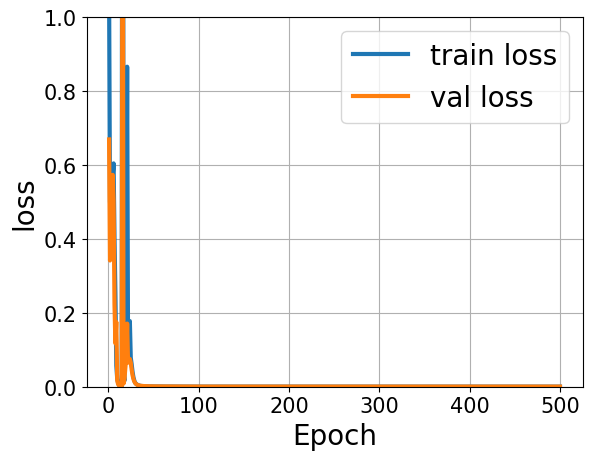

In [26]:
plt.figure()
plt.plot(range(1,num_epochs+1), loss_history, label = "train loss", linewidth=3)
plt.plot(range(1,num_epochs+1), val_loss_history, label = "val loss", linewidth=3)
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 1)
plt.grid()

* __packed padding__: ok
    - resolving unreasonable overshooting
    - resolving the issue of zero padding and not knowing the original length
* __batch normalization__
    - so far overshooting
* __learning rate__
    - a bit large (0.001 -> 0.005) works better
* __layer and hidden size__: ok
    - not too much large, but larger one works well
* last batch dropout
    - works okay
* __gradient clipping__
* __gradient scheduler for decay__
* __dropout__: ok 

In [27]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    # correct_r = 0

    for batch_sequences, batch_labels in test_loader:
        # Data pre-processing
        lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)
        batch_sequences = batch_sequences.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        output = model(batch_sequences, lengths)
        total += batch_labels.size(0)      
        # print("output {}".format(output))

        ### prediction
        if binary_classification:
            pred = torch.round(output.squeeze())  # rounds to the nearest integer
            correct_tensor = pred.eq(batch_labels.float().view_as(pred))

        else: 
            _, pred = torch.max(output, 1) # multi classifier
            correct_tensor = pred.eq(batch_labels.long().view_as(pred))
        
        # correct_tensor = pred.eq(batch_labels.float().view_as(pred))
        current_correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        correct += np.sum(current_correct)
        
        y_true.extend(batch_labels.tolist())
        y_pred.extend(pred.tolist())

    print('Test Accuracy of the model on the test data: {} %'.format(100 * correct / total))

# Calculate other evaluation metrics (precision, recall, F1-score)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Test Accuracy of the model on the test data: 100.0 %
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [28]:
torch.save(model.state_dict(), 'test-weight.pth')

In [29]:
# https://discuss.pytorch.org/t/how-to-use-lstm-for-a-time-series-classification-task/130559/4
# https://notebook.community/Diyago/Machine-Learning-scripts/NLP/LSTM%20RNN/Sentiment%20pytorch/Sentiment_RNN

### Data input and output setup aimed for ROS topic

In [30]:
def final_test(final_test_file_idx):
    # 1) data loading
    unpickled_df = pd.read_pickle("./dk_csv_20180101/binary/aisdk_20180101_{}.pkl".format(str(final_test_file_idx)))
    

    # 2) data pre-processing
    # 2-1) data preparation
    unpickled_df['heading_converted']  = np.deg2rad(unpickled_df['Heading'])
    # lambda function method: very fast! 
    # https://stackoverflow.com/questions/71249186/applying-function-to-column-in-a-dataframe

    # TODO from ROS no need to conversion of NED to Robotic? 
    unpickled_df['heading_converted'] = unpickled_df['heading_converted'].apply(convert_from_NED_to_Robotic)
    obj_id = unpickled_df['obj_index']

    # crop before passing
    crop_unpickled_df = get_trajectory_before_pass(unpickled_df, [obj_id[0]])
    # print(crop_unpickled_df)

    features = crop_unpickled_df[columns_for_x].values.tolist()
    label = 0 if crop_unpickled_df[columns_for_y].values[-1][0] == "L" else 1 # last row, only char

    print(np.shape([features]))
    print("label {}".format(label))

    # 2-2) data padding
    # or should we use [] for batch
    pad_feature = pad_sequence([torch.tensor(features)], batch_first=True)
    # pad_feature = pad_sequence(torch.tensor(features), batch_first=True)
    print(np.shape(pad_feature))

    # lengths = torch.sum(pad_feature.sum(dim=2) != 0, dim=1)
    # print(lengths)

    # prediction
    predict(model, pad_feature)

In [31]:
# Test the model
def predict(model, streaming_input, sequence_length=None):
    """
    Args:
        - streaming_input: (torch.tensor) [B, L, F]: batch, length, feature_size as padded feature
    """

    # TODO use sequence length later for fixed data streaming length

    model.eval()
    with torch.no_grad():  
        # Data pre-processing
        lengths = torch.sum(streaming_input.sum(dim=2) != 0, dim=1)
        streaming_sequences = streaming_input.to(device)
        # batch_labels = streaming_input.to(device)

        # Forward pass
        output = model(batch_sequences, lengths)     

        ### prediction
        # TODO how to output probability
        print("------------ result ------------")
        if binary_classification:
            print("before round {}".format(output))
            pred = torch.round(output.squeeze())  # rounds to the nearest integer
            
            print("prdiction value {}".format(pred))
        else: 
            _, pred = torch.max(output, 1) # multi classifier
            correct_tensor = pred.eq(batch_labels.long().view_as(pred))


        if (pred.item() == 0):
            print("obstacle is L passing")
        else:
            print("obstacls is R passing")

In [32]:
final_test_file_idx = 300
final_test(final_test_file_idx)

KeyError: "['sin_comp_bearing', 'cos_comp_bearing'] not in index"

### Multi class trial

In [ ]:
"""
if not binary_classification:
    # Training loop
    model.train()
    loss_history =torch.tensor([])
    val_loss_history =torch.tensor([])

    for epoch in range(num_epochs):
        ##################################################################
        ##### training 
        ##################################################################
        for batch_sequences, batch_labels in train_loader:
            optimizer.zero_grad()

            # 1) Calculate the sequence lengths for the current batch
            lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)

            batch_sequences = batch_sequences.to(device)
            batch_labels = batch_labels.to(device)
            
            # 2) Forward pass
            output = model(batch_sequences, lengths)
            
            # this is possible, but I did instead output squeeze to match dimension
            # batch_labels = torch.unsqueeze(batch_labels, 1)

            # 3) Compute the loss       
            # loss = criterion(output.squeeze(), batch_labels.float()) # MJ 2023.07.31
            loss = criterion(output.squeeze(), batch_labels.long())

            # 4) Backward pass and optimization
            loss.backward()
            
            # 5) Gradient Clipping
            # 5-1) Gradient Norm Clipping
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            # 5-2) Gradient Value Clipping
            # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        
            optimizer.step()

        loss_history = torch.cat([loss_history, torch.tensor([loss.item()]).float()], dim=0)

        # Print the loss for every epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}")

        ##################################################################
        ##### Validation
        ##################################################################
        # val_steps = 0
        # total_val = 0
        # correct_val = 0
        # for i, data in enumerate(val_loader, 0):
        #     with torch.no_grad():
        #         batch_sequences_val, batch_labels_val = data

        #         # 1) Calculate the sequence lengths for the current batch
        #         lengths_val = torch.sum(batch_sequences_val.sum(dim=2) != 0, dim=1)
        #         batch_sequences_val = batch_sequences_val.to(device)
        #         batch_labels_val = batch_labels_val.to(device)

        #         # 2) Forward pass
        #         output_val = model(batch_sequences_val, lengths_val)
        #         total_val += batch_labels_val.size(0)      

        #         ### prediction
                # if binary_classification:
                #     pred = torch.round(output.squeeze())  # rounds to the nearest integer
                # else: 
                #     _, pred = torch.max(output, 1) # multi classifier
                
        #         # correct_tensor_val = pred_val.eq(batch_labels_val.float().view_as(pred_val))
        #         correct_tensor_val = pred_val.eq(batch_labels_val.long().view_as(pred_val)) # MJ
        #         current_correct_val = np.squeeze(correct_tensor_val.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor_val.cpu().numpy())
        #         correct_val += np.sum(current_correct_val)

        #         # loss_val = criterion(output_val.squeeze(), batch_labels_val.float())
        #         loss_val = criterion(output_val.squeeze(), batch_labels_val.long())
        #         val_steps += 1

        # val_loss_history = torch.cat([val_loss_history, torch.tensor([loss_val.item()]).float()], dim=0)
        # print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {loss_val.item()}")

        
        ##################################################################
        ##### scheduler
        ##################################################################
        scheduler.step()

    print("Finished Training")
"""

'\nif not binary_classification:\n    # Training loop\n    model.train()\n    loss_history =torch.tensor([])\n    val_loss_history =torch.tensor([])\n\n    for epoch in range(num_epochs):\n        ##################################################################\n        ##### training \n        ##################################################################\n        for batch_sequences, batch_labels in train_loader:\n            optimizer.zero_grad()\n\n            # 1) Calculate the sequence lengths for the current batch\n            lengths = torch.sum(batch_sequences.sum(dim=2) != 0, dim=1)\n\n            batch_sequences = batch_sequences.to(device)\n            batch_labels = batch_labels.to(device)\n            \n            # 2) Forward pass\n            output = model(batch_sequences, lengths)\n            \n            # this is possible, but I did instead output squeeze to match dimension\n            # batch_labels = torch.unsqueeze(batch_labels, 1)\n\n            # 3) C